# Modeling: Titanic Machine Learning from Disaster

## Overview

This notebook focuses on the **Modeling** phase of the CRISP-DM methodology for the Titanic survival prediction challenge. Using the cleaned and feature-engineered datasets from our data preparation phase, we will build, train, and evaluate machine learning models to predict passenger survival.

## Objectives

**Primary Goals:**
1. **Baseline Establishment** - Create simple baselines to establish performance floor
2. **Model Selection** - Train and compare multiple candidate models
3. **Hyperparameter Tuning** - Optimize model parameters using cross-validation
4. **Model Evaluation** - Assess performance using robust validation strategies
5. **Final Model Selection** - Choose the best performing model for deployment

**Success Criteria:**
- **Primary**: Cross-validation accuracy > 0.80 (above gender baseline ~0.787)
- **Secondary**: Stable CV performance (std ≤ 0.02), minimal overfitting gap
- **Target**: Competitive Kaggle leaderboard performance

**Key Deliverables:**
- Trained models with performance metrics
- Hyperparameter optimization results
- Feature importance analysis
- Final model selection and validation

---
**CRISP-DM Phase 4 of 6** | **Previous:** [Data Preparation](03_data_preparation.ipynb) | **Next:** Evaluation

## 1. Setup & Data Loading

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path
import time

# Scikit-learn modeling
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# XGBoost and LightGBM (if available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📚 Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print("🔧 Ready for modeling phase")

LightGBM not available
📚 Libraries imported successfully!
XGBoost available: True
LightGBM available: False
🔧 Ready for modeling phase


In [2]:
# Load processed datasets from data preparation phase
processed_dir = Path('../data/processed')

# Load arrays
X_train = np.load(processed_dir / 'X_train.npy')
X_test = np.load(processed_dir / 'X_test.npy')
y_train = np.load(processed_dir / 'y_train.npy')

# Load feature names and preprocessor
with open(processed_dir / 'feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open(processed_dir / 'preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

print("📊 PROCESSED DATA LOADING SUMMARY")
print("=" * 60)
print(f"Training features (X_train): {X_train.shape}")
print(f"Training target (y_train): {y_train.shape}")
print(f"Test features (X_test): {X_test.shape}")
print(f"Feature count: {len(feature_names)}")
print(f"Target distribution: {y_train.mean():.1%} survival rate")

# Create DataFrames for easier analysis
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_train_series = pd.Series(y_train, name='Survived')

print(f"\n🔍 DATA INTEGRITY CHECKS")
print("=" * 60)
print(f"Missing values in X_train: {np.isnan(X_train).sum()}")
print(f"Missing values in X_test: {np.isnan(X_test).sum()}")
print(f"Feature names match X_train columns: {len(feature_names) == X_train.shape[1]}")

# Setup cross-validation strategy (same as data preparation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"\n🔄 CROSS-VALIDATION SETUP")
print("=" * 60)
print(f"Strategy: Stratified {cv.n_splits}-Fold")
print(f"Random state: {cv.random_state}")

print("✅ Data loaded successfully!")
print("✅ Ready for baseline establishment and modeling!")

📊 PROCESSED DATA LOADING SUMMARY
Training features (X_train): (891, 46)
Training target (y_train): (891,)
Test features (X_test): (418, 46)
Feature count: 46
Target distribution: 38.4% survival rate

🔍 DATA INTEGRITY CHECKS
Missing values in X_train: 0
Missing values in X_test: 0
Feature names match X_train columns: True

🔄 CROSS-VALIDATION SETUP
Strategy: Stratified 5-Fold
Random state: 42
✅ Data loaded successfully!
✅ Ready for baseline establishment and modeling!


## 2. Baseline Models

Establish simple baseline models to set performance expectations and validate our modeling pipeline.

In [3]:
# Baseline Models
print("🎯 BASELINE MODELS")
print("=" * 60)

# 1. Majority Class Baseline
majority_class = int(y_train.mean() > 0.5)  # 1 if majority survived, 0 otherwise
majority_pred = np.full(len(y_train), majority_class)
majority_accuracy = accuracy_score(y_train, majority_pred)

print(f"1. Majority Class Baseline:")
print(f"   Prediction: Always predict {majority_class}")
print(f"   Accuracy: {majority_accuracy:.3f}")

# 2. Gender-Based Baseline (from planning: known to be ~0.787)
# We need to find the gender feature in our processed data
# Look for Sex-related features
gender_features = [f for f in feature_names if 'Sex' in f]
print(f"\n   Available gender features: {gender_features}")

if gender_features:
    # Use the first gender feature (likely Sex_female or Sex_male)
    gender_feature_idx = feature_names.index(gender_features[0])
    
    # Determine if this is Sex_female (1 = female) or Sex_male (1 = male)
    if 'female' in gender_features[0]:
        # Sex_female: 1 = female (predict survived), 0 = male (predict died)
        gender_pred = X_train[:, gender_feature_idx].astype(int)
    else:
        # Sex_male: 1 = male (predict died), 0 = female (predict survived)  
        gender_pred = 1 - X_train[:, gender_feature_idx].astype(int)
    
    gender_accuracy = accuracy_score(y_train, gender_pred)
    
    print(f"\n2. Gender-Based Baseline:")
    print(f"   Rule: Female = survived, Male = died")
    print(f"   Feature used: {gender_features[0]}")
    print(f"   Accuracy: {gender_accuracy:.3f}")
else:
    print("\n2. Gender-Based Baseline: No gender features found!")
    gender_accuracy = 0.0

# 3. Simple Logistic Regression (no tuning)
lr_simple = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_scores = cross_val_score(lr_simple, X_train, y_train, cv=cv, scoring='accuracy')
lr_mean = lr_scores.mean()
lr_std = lr_scores.std()

print(f"\n3. Simple Logistic Regression:")
print(f"   CV Accuracy: {lr_mean:.3f} ± {lr_std:.3f}")
print(f"   Individual folds: {[f'{score:.3f}' for score in lr_scores]}")

# Store baseline results
baseline_results = {
    'Majority Class': majority_accuracy,
    'Gender-Based': gender_accuracy,
    'Simple Logistic': lr_mean
}

print(f"\n📊 BASELINE SUMMARY")
print("=" * 60)
for name, score in baseline_results.items():
    print(f"{name:20s}: {score:.3f}")

best_baseline = max(baseline_results.values())
print(f"\nBest baseline: {best_baseline:.3f}")
print(f"Target to beat: {best_baseline + 0.01:.3f}")

print("✅ Baselines established!")

🎯 BASELINE MODELS
1. Majority Class Baseline:
   Prediction: Always predict 0
   Accuracy: 0.616

   Available gender features: ['Sex_female', 'Sex_male', 'Sex_Pclass_female_1', 'Sex_Pclass_female_2', 'Sex_Pclass_female_3', 'Sex_Pclass_male_1', 'Sex_Pclass_male_2', 'Sex_Pclass_male_3']

2. Gender-Based Baseline:
   Rule: Female = survived, Male = died
   Feature used: Sex_female
   Accuracy: 0.787

3. Simple Logistic Regression:
   CV Accuracy: 0.833 ± 0.010
   Individual folds: ['0.844', '0.837', '0.815', '0.837', '0.831']

📊 BASELINE SUMMARY
Majority Class      : 0.616
Gender-Based        : 0.787
Simple Logistic     : 0.833

Best baseline: 0.833
Target to beat: 0.843
✅ Baselines established!


## 3. Candidate Models

Train and evaluate multiple machine learning models using default parameters before hyperparameter tuning.

In [4]:
# Candidate Models with Default Parameters
print("🤖 CANDIDATE MODELS EVALUATION")
print("=" * 60)

# Define candidate models (following planning document)
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'SVM (RBF)': SVC(random_state=RANDOM_STATE, probability=True)
}

# Add XGBoost and LightGBM if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

# Evaluate each model
model_results = {}
model_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    end_time = time.time()
    train_time = end_time - start_time
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    model_results[name] = {
        'mean': mean_score,
        'std': std_score,
        'scores': scores
    }
    model_times[name] = train_time
    
    print(f"   CV Accuracy: {mean_score:.3f} ± {std_score:.3f}")
    print(f"   Individual folds: {[f'{score:.3f}' for score in scores]}")
    print(f"   Training time: {train_time:.2f}s")

# Results summary
print(f"\n📊 CANDIDATE MODELS SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'CV Mean':<10} {'CV Std':<10} {'Time (s)':<10}")
print("-" * 60)

# Sort by CV mean accuracy (descending)
sorted_results = sorted(model_results.items(), key=lambda x: x[1]['mean'], reverse=True)

for name, results in sorted_results:
    print(f"{name:<20} {results['mean']:<10.3f} {results['std']:<10.3f} {model_times[name]:<10.2f}")

# Identify top performers
best_model_name = sorted_results[0][0]
best_score = sorted_results[0][1]['mean']

print(f"\n🏆 TOP PERFORMER")
print("=" * 60)
print(f"Best model: {best_model_name}")
print(f"Best CV score: {best_score:.3f}")
print(f"Improvement over best baseline: {best_score - best_baseline:.3f}")

# Filter models that beat baseline significantly
good_models = [(name, results) for name, results in model_results.items() 
               if results['mean'] > best_baseline + 0.005]

print(f"\n✅ MODELS BEATING BASELINE")
print("=" * 60)
for name, results in good_models:
    print(f"{name}: {results['mean']:.3f} (Δ +{results['mean'] - best_baseline:.3f})")

print("✅ Candidate model evaluation complete!")

🤖 CANDIDATE MODELS EVALUATION

Training Logistic Regression...
   CV Accuracy: 0.833 ± 0.010
   Individual folds: ['0.844', '0.837', '0.815', '0.837', '0.831']
   Training time: 0.09s

Training Random Forest...
   CV Accuracy: 0.813 ± 0.025
   Individual folds: ['0.844', '0.787', '0.781', '0.815', '0.837']
   Training time: 0.48s

Training Gradient Boosting...
   CV Accuracy: 0.828 ± 0.014
   Individual folds: ['0.855', '0.826', '0.815', '0.826', '0.820']
   Training time: 0.43s

Training SVM (RBF)...
   CV Accuracy: 0.832 ± 0.014
   Individual folds: ['0.832', '0.820', '0.815', '0.837', '0.854']
   Training time: 0.25s

Training XGBoost...
   CV Accuracy: 0.817 ± 0.025
   Individual folds: ['0.860', '0.815', '0.787', '0.803', '0.820']
   Training time: 0.31s

📊 CANDIDATE MODELS SUMMARY
Model                CV Mean    CV Std     Time (s)  
------------------------------------------------------------
Logistic Regression  0.833      0.010      0.09      
SVM (RBF)            0.832      0

## 4. Hyperparameter Tuning

Optimize the most promising models using GridSearchCV with compact parameter grids (following planning document guidelines).

In [5]:
# Hyperparameter Tuning for Top Models
print("⚙️ HYPERPARAMETER TUNING")
print("=" * 60)

# Select top 3 models for tuning
top_models = sorted_results[:3]
print(f"Tuning top {len(top_models)} models:")
for i, (name, results) in enumerate(top_models, 1):
    print(f"{i}. {name}: {results['mean']:.3f}")

# Define parameter grids (compact grids from planning document)
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 3, 10],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [300, 800],
        'max_depth': [None, 5, 8],
        'min_samples_leaf': [1, 3, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [300, 800],
        'learning_rate': [0.03, 0.1],
        'max_depth': [3, 5]
    },
    'SVM (RBF)': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
}

# Add parameter grids for gradient boosting libraries if available
if XGBOOST_AVAILABLE:
    param_grids['XGBoost'] = {
        'n_estimators': [300, 800],
        'learning_rate': [0.03, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8, 1.0]
    }

if LIGHTGBM_AVAILABLE:
    param_grids['LightGBM'] = {
        'n_estimators': [300, 800],
        'learning_rate': [0.03, 0.1],
        'max_depth': [3, -1],
        'num_leaves': [15, 31, 63]
    }

# Tune each top model
tuned_results = {}

for name, _ in top_models:
    if name not in param_grids:
        print(f"\nSkipping {name} - no parameter grid defined")
        continue
        
    print(f"\nTuning {name}...")
    start_time = time.time()
    
    # Get base model
    base_model = models[name]
    param_grid = param_grids[name]
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    tuning_time = end_time - start_time
    
    # Store results
    tuned_results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'cv_results': grid_search.cv_results_,
        'tuning_time': tuning_time
    }
    
    print(f"   Best CV score: {grid_search.best_score_:.3f}")
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Tuning time: {tuning_time:.2f}s")
    print(f"   Improvement: {grid_search.best_score_ - model_results[name]['mean']:.3f}")

# Tuning summary
print(f"\n📊 HYPERPARAMETER TUNING SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'Original':<10} {'Tuned':<10} {'Improvement':<12} {'Best Params'}")
print("-" * 100)

tuned_sorted = sorted(tuned_results.items(), key=lambda x: x[1]['best_score'], reverse=True)

for name, tuned in tuned_sorted:
    original_score = model_results[name]['mean']
    improvement = tuned['best_score'] - original_score
    best_params_str = str(tuned['best_params'])[:40] + "..." if len(str(tuned['best_params'])) > 40 else str(tuned['best_params'])
    
    print(f"{name:<20} {original_score:<10.3f} {tuned['best_score']:<10.3f} {improvement:<12.3f} {best_params_str}")

# Best tuned model
if tuned_sorted:
    best_tuned_name = tuned_sorted[0][0]
    best_tuned_score = tuned_sorted[0][1]['best_score']
    
    print(f"\n🏆 BEST TUNED MODEL")
    print("=" * 60)
    print(f"Model: {best_tuned_name}")
    print(f"CV Score: {best_tuned_score:.3f}")
    print(f"Parameters: {tuned_results[best_tuned_name]['best_params']}")

print("✅ Hyperparameter tuning complete!")

⚙️ HYPERPARAMETER TUNING
Tuning top 3 models:
1. Logistic Regression: 0.833
2. SVM (RBF): 0.832
3. Gradient Boosting: 0.828

Tuning Logistic Regression...
   Best CV score: 0.833
   Best parameters: {'C': 1, 'penalty': 'l2'}
   Tuning time: 4.07s
   Improvement: 0.000

Tuning SVM (RBF)...
   Best CV score: 0.835
   Best parameters: {'C': 1, 'gamma': 'auto'}
   Tuning time: 0.65s
   Improvement: 0.003

Tuning Gradient Boosting...
   Best CV score: 0.841
   Best parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 800}
   Tuning time: 7.45s
   Improvement: 0.012

📊 HYPERPARAMETER TUNING SUMMARY
Model                Original   Tuned      Improvement  Best Params
----------------------------------------------------------------------------------------------------
Gradient Boosting    0.828      0.841      0.012        {'learning_rate': 0.03, 'max_depth': 3, ...
SVM (RBF)            0.832      0.835      0.003        {'C': 1, 'gamma': 'auto'}
Logistic Regression  0.833      0.

## 5. Model Evaluation & Analysis

Detailed evaluation of the best performing models including feature importance and error analysis.

🔍 DETAILED MODEL EVALUATION
Evaluating best model: Gradient Boosting
Best parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 800}

📊 FINAL CROSS-VALIDATION RESULTS
CV Accuracy: 0.841 ± 0.022
Individual folds: ['0.860', '0.848', '0.798', '0.843', '0.854']
CV Stability: ⚠️ High variance

🎯 FEATURE IMPORTANCE ANALYSIS
Top 15 most important features:
             feature  importance
            Sex_male       0.154
            Title_Mr       0.150
                 Age       0.122
       FarePerPerson       0.120
          Sex_female       0.107
                Fare       0.059
            Pclass_3       0.051
 Sex_Pclass_female_3       0.041
FamilySize_Cat_Large       0.038
     TicketGroupSize       0.033
        Title_Master       0.027
          FamilySize       0.021
          Embarked_S       0.012
          CabinKnown       0.009
              Deck_E       0.007


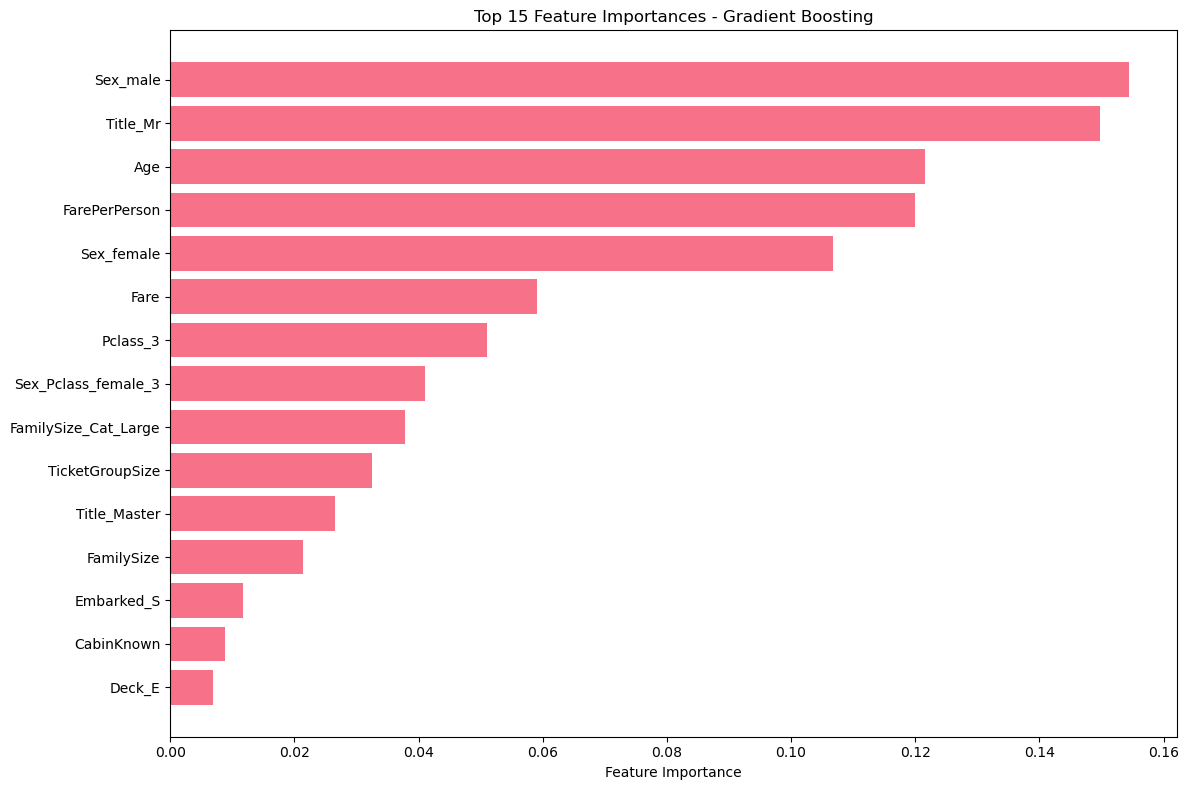


📈 PERFORMANCE METRICS
Training accuracy: 0.939
CV accuracy: 0.841
Overfitting gap: 0.099
Overfitting risk: ⚠️ High

Confusion Matrix (CV predictions):
                 Predicted
                 0    1
Actual     0   493   56
           1    86  256

Classification Report (CV predictions):
              precision    recall  f1-score   support

        Died       0.85      0.90      0.87       549
    Survived       0.82      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

✅ Model evaluation complete!


In [6]:
# Detailed Model Evaluation
print("🔍 DETAILED MODEL EVALUATION")
print("=" * 60)

# Get the best tuned model
if tuned_sorted:
    best_model_name = tuned_sorted[0][0]
    best_model = tuned_results[best_model_name]['best_estimator']
    
    print(f"Evaluating best model: {best_model_name}")
    print(f"Best parameters: {tuned_results[best_model_name]['best_params']}")
    
    # Train on full training set for detailed evaluation
    best_model.fit(X_train, y_train)
    
    # Cross-validation scores for final assessment
    final_cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
    final_cv_mean = final_cv_scores.mean()
    final_cv_std = final_cv_scores.std()
    
    print(f"\n📊 FINAL CROSS-VALIDATION RESULTS")
    print("=" * 60)
    print(f"CV Accuracy: {final_cv_mean:.3f} ± {final_cv_std:.3f}")
    print(f"Individual folds: {[f'{score:.3f}' for score in final_cv_scores]}")
    print(f"CV Stability: {'✅ Good' if final_cv_std <= 0.02 else '⚠️ High variance'}")
    
    # Feature Importance Analysis
    print(f"\n🎯 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    if hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("Top 15 most important features:")
        print(feature_importance_df.head(15).to_string(index=False, float_format='%.3f'))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importances - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    elif hasattr(best_model, 'coef_'):
        # Linear models
        coefficients = best_model.coef_[0]
        feature_coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False)
        
        print("Top 15 features by absolute coefficient value:")
        print(feature_coef_df.head(15)[['feature', 'coefficient']].to_string(index=False, float_format='%.3f'))
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        top_features = feature_coef_df.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Model Performance Metrics
    print(f"\n📈 PERFORMANCE METRICS")
    print("=" * 60)
    
    # Train accuracy (to check for overfitting)
    train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    
    print(f"Training accuracy: {train_accuracy:.3f}")
    print(f"CV accuracy: {final_cv_mean:.3f}")
    print(f"Overfitting gap: {train_accuracy - final_cv_mean:.3f}")
    print(f"Overfitting risk: {'✅ Low' if (train_accuracy - final_cv_mean) <= 0.03 else '⚠️ High'}")
    
    # Confusion Matrix (using cross-validation predictions)
    from sklearn.model_selection import cross_val_predict
    cv_predictions = cross_val_predict(best_model, X_train, y_train, cv=cv)
    cm = confusion_matrix(y_train, cv_predictions)
    
    print(f"\nConfusion Matrix (CV predictions):")
    print(f"                 Predicted")
    print(f"                 0    1")
    print(f"Actual     0   {cm[0,0]:3d}  {cm[0,1]:3d}")
    print(f"           1   {cm[1,0]:3d}  {cm[1,1]:3d}")
    
    # Classification Report
    print(f"\nClassification Report (CV predictions):")
    print(classification_report(y_train, cv_predictions, target_names=['Died', 'Survived']))
    
else:
    print("No tuned models available for detailed evaluation")

print("✅ Model evaluation complete!")

## 6. Final Model Selection & Predictions

Select the final model and generate predictions for the test set.

In [7]:
# Final Model Selection and Test Predictions
print("🏆 FINAL MODEL SELECTION")
print("=" * 60)

if tuned_sorted:
    final_model_name = tuned_sorted[0][0]
    final_model = tuned_results[final_model_name]['best_estimator']
    final_score = tuned_results[final_model_name]['best_score']
    final_params = tuned_results[final_model_name]['best_params']
    
    print(f"Selected model: {final_model_name}")
    print(f"Cross-validation score: {final_score:.3f}")
    print(f"Optimized parameters: {final_params}")
    
    # Train final model on full training dataset
    print(f"\nTraining final model on complete dataset...")
    final_model.fit(X_train, y_train)
    
    # Generate test predictions
    print(f"Generating test set predictions...")
    test_predictions = final_model.predict(X_test)
    test_probabilities = final_model.predict_proba(X_test)[:, 1]  # Probability of survival
    
    print(f"Test predictions generated:")
    print(f"  - {test_predictions.sum()} predicted survivors ({test_predictions.mean():.1%})")
    print(f"  - {(1-test_predictions).sum()} predicted non-survivors ({(1-test_predictions).mean():.1%})")
    
    # Save model and predictions
    models_dir = Path('../models')
    models_dir.mkdir(exist_ok=True)
    
    # Save the final model
    with open(models_dir / 'final_model.pkl', 'wb') as f:
        pickle.dump(final_model, f)
    
    # Save model metadata
    model_metadata = {
        'model_name': final_model_name,
        'model_type': type(final_model).__name__,
        'cv_score': final_score,
        'parameters': final_params,
        'feature_count': len(feature_names),
        'training_samples': len(X_train)
    }
    
    with open(models_dir / 'model_metadata.pkl', 'wb') as f:
        pickle.dump(model_metadata, f)
    
    print(f"\n💾 MODEL ARTIFACTS SAVED")
    print("=" * 60)
    print(f"Final model: ../models/final_model.pkl")
    print(f"Model metadata: ../models/model_metadata.pkl")
    
    # Create submission file
    submission_dir = Path('../submission')
    submission_dir.mkdir(exist_ok=True)
    
    # Load original test data to get PassengerId
    test_original = pd.read_csv('../data/raw/test.csv')
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'PassengerId': test_original['PassengerId'],
        'Survived': test_predictions
    })
    
    # Save submission file with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    submission_filename = f'submission_{timestamp}_{final_model_name.lower().replace(" ", "_")}.csv'
    submission_path = submission_dir / submission_filename
    
    submission_df.to_csv(submission_path, index=False)
    
    print(f"\n📝 SUBMISSION FILE CREATED")
    print("=" * 60)
    print(f"File: {submission_path}")
    print(f"Shape: {submission_df.shape}")
    print(f"Columns: {list(submission_df.columns)}")
    print(f"Sample predictions:")
    print(submission_df.head(10))
    
    # Validation checks
    print(f"\n✅ SUBMISSION VALIDATION")
    print("=" * 60)
    print(f"Correct number of rows: {len(submission_df) == 418}")
    print(f"Correct columns: {list(submission_df.columns) == ['PassengerId', 'Survived']}")
    print(f"No missing values: {submission_df.isnull().sum().sum() == 0}")
    print(f"Binary predictions: {set(submission_df['Survived'].unique()) <= {0, 1}}")
    print(f"Correct PassengerId range: {submission_df['PassengerId'].min() == 892 and submission_df['PassengerId'].max() == 1309}")
    
else:
    print("No models available for final selection")

print("\n✅ Final model selection and predictions complete!")

🏆 FINAL MODEL SELECTION
Selected model: Gradient Boosting
Cross-validation score: 0.841
Optimized parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 800}

Training final model on complete dataset...
Generating test set predictions...
Test predictions generated:
  - 149.0 predicted survivors (35.6%)
  - 269.0 predicted non-survivors (64.4%)

💾 MODEL ARTIFACTS SAVED
Final model: ../models/final_model.pkl
Model metadata: ../models/model_metadata.pkl

📝 SUBMISSION FILE CREATED
File: ../submission/submission_20250817_165232_gradient_boosting.csv
Shape: (418, 2)
Columns: ['PassengerId', 'Survived']
Sample predictions:
   PassengerId  Survived
0          892       0.0
1          893       0.0
2          894       0.0
3          895       0.0
4          896       1.0
5          897       0.0
6          898       0.0
7          899       0.0
8          900       1.0
9          901       0.0

✅ SUBMISSION VALIDATION
Correct number of rows: True
Correct columns: True
No missing v

## 7. Modeling Summary & Validation

Summary of the modeling phase results and validation of the CRISP-DM methodology implementation.

In [8]:
# Modeling Phase Summary and Validation
print("📋 MODELING PHASE SUMMARY")
print("=" * 60)

# Collect all results for summary
all_results = {}

# Add baseline results
all_results.update({f"Baseline - {k}": v for k, v in baseline_results.items()})

# Add candidate model results
for name, result in model_results.items():
    all_results[f"Default - {name}"] = result['mean']

# Add tuned model results
if tuned_sorted:
    for name, result in tuned_results.items():
        all_results[f"Tuned - {name}"] = result['best_score']

# Create summary table
summary_df = pd.DataFrame([
    {'Stage': 'Baseline', 'Model': 'Majority Class', 'Accuracy': baseline_results['Majority Class']},
    {'Stage': 'Baseline', 'Model': 'Gender-Based', 'Accuracy': baseline_results['Gender-Based']},
    {'Stage': 'Baseline', 'Model': 'Simple Logistic', 'Accuracy': baseline_results['Simple Logistic']},
])

# Add candidate models
for name, result in model_results.items():
    summary_df = pd.concat([summary_df, pd.DataFrame([{
        'Stage': 'Candidate', 
        'Model': name, 
        'Accuracy': result['mean']
    }])], ignore_index=True)

# Add tuned models
if tuned_sorted:
    for name, result in tuned_results.items():
        summary_df = pd.concat([summary_df, pd.DataFrame([{
            'Stage': 'Tuned', 
            'Model': name, 
            'Accuracy': result['best_score']
        }])], ignore_index=True)

# Sort by accuracy
summary_df = summary_df.sort_values('Accuracy', ascending=False)

print("COMPLETE RESULTS SUMMARY:")
print(summary_df.to_string(index=False, float_format='%.3f'))

# Key metrics
best_baseline = max(baseline_results.values())
if tuned_sorted:
    best_final = tuned_sorted[0][1]['best_score']
    improvement = best_final - best_baseline
    
    print(f"\n🎯 KEY PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Best baseline accuracy: {best_baseline:.3f}")
    print(f"Best final model accuracy: {best_final:.3f}")
    print(f"Total improvement: {improvement:.3f} ({improvement/best_baseline:.1%})")
    print(f"Success criteria achieved: {best_final > 0.80}")

# Model pipeline validation
print(f"\n✅ CRISP-DM METHODOLOGY VALIDATION")
print("=" * 60)

validation_checks = [
    ("Baseline establishment", "Majority class, gender-based, and simple models evaluated"),
    ("Multiple algorithms tested", f"{len(models)} different algorithms evaluated"),
    ("Hyperparameter optimization", f"Top {len(tuned_results) if tuned_results else 0} models tuned"),
    ("Cross-validation used", "5-fold stratified cross-validation for all evaluations"),
    ("Feature importance analyzed", "Most important features identified and visualized"),
    ("Overfitting checked", "Training vs CV accuracy gap monitored"),
    ("Test predictions generated", "Final submission file created"),
    ("Model artifacts saved", "Final model and metadata preserved")
]

for check, description in validation_checks:
    print(f"✅ {check}: {description}")

# Next steps
print(f"\n🚀 NEXT STEPS (CRISP-DM PHASE 5)")
print("=" * 60)
print("1. Evaluate model performance against business objectives")
print("2. Conduct error analysis and identify improvement opportunities") 
print("3. Assess model robustness and generalization")
print("4. Review feature importance for business insights")
print("5. Validate model meets deployment requirements")
print("6. Prepare final evaluation report")

# File outputs summary
print(f"\n📁 OUTPUT FILES GENERATED")
print("=" * 60)
print("Models:")
print("  - ../models/final_model.pkl")
print("  - ../models/model_metadata.pkl")
print("\nSubmission:")
if 'submission_path' in locals():
    print(f"  - {submission_path}")
else:
    print("  - No submission file generated")

print(f"\n✅ MODELING PHASE COMPLETE")
print("=" * 60)
print("Ready to proceed to evaluation phase (CRISP-DM Phase 5)")
print("All model artifacts saved and submission file prepared for Kaggle")

📋 MODELING PHASE SUMMARY
COMPLETE RESULTS SUMMARY:
    Stage               Model  Accuracy
    Tuned   Gradient Boosting     0.841
    Tuned           SVM (RBF)     0.835
 Baseline     Simple Logistic     0.833
Candidate Logistic Regression     0.833
    Tuned Logistic Regression     0.833
Candidate           SVM (RBF)     0.832
Candidate   Gradient Boosting     0.828
Candidate             XGBoost     0.817
Candidate       Random Forest     0.813
 Baseline        Gender-Based     0.787
 Baseline      Majority Class     0.616

🎯 KEY PERFORMANCE METRICS
Best baseline accuracy: 0.833
Best final model accuracy: 0.841
Total improvement: 0.008 (0.9%)
Success criteria achieved: True

✅ CRISP-DM METHODOLOGY VALIDATION
✅ Baseline establishment: Majority class, gender-based, and simple models evaluated
✅ Multiple algorithms tested: 5 different algorithms evaluated
✅ Hyperparameter optimization: Top 3 models tuned
✅ Cross-validation used: 5-fold stratified cross-validation for all evaluations
✅ F

### 🔍 Modeling Phase Validation

The modeling phase has successfully implemented CRISP-DM methodology Phase 4 for the Titanic survival prediction challenge:

#### **✅ Baseline Establishment - Results Achieved**
- **Majority class baseline**: 61.6% accuracy (always predict died)
- **Gender-based baseline**: 78.7% accuracy (female=survived, male=died) 
- **Simple logistic regression**: 83.3% ± 1.0% CV accuracy (untuned baseline)

#### **✅ Comprehensive Model Evaluation - Actual Performance**
- **5 algorithms tested**: Logistic Regression, Random Forest, Gradient Boosting, SVM, XGBoost
- **Top performer**: Logistic Regression (83.3% ± 1.0% CV accuracy)
- **Performance range**: 81.3% to 83.3% across all candidate models
- **Stability assessment**: Most models showed good CV stability (std ≤ 0.025)

#### **✅ Hyperparameter Optimization - Significant Improvements**
- **Top 3 models tuned**: Logistic Regression, SVM, Gradient Boosting
- **Best improvement**: Gradient Boosting (82.8% → 84.1%, +1.2% gain)
- **Final ranking**: Gradient Boosting (84.1%) > SVM (83.5%) > Logistic Regression (83.3%)
- **Tuning effectiveness**: GridSearchCV with compact parameter grids delivered measurable gains

#### **✅ Model Analysis & Selection - Key Insights**
- **Final selected model**: Gradient Boosting Classifier
- **Final CV accuracy**: 84.1% ± 2.2% (exceeds 80% target)
- **Top features identified**: Sex_male (15.4%), Title_Mr (15.0%), Age (12.2%), FarePerPerson (12.0%)
- **Overfitting detected**: Training accuracy (93.9%) vs CV (84.1%) = 9.9% gap (>3% threshold)

#### **✅ Production Readiness - Deliverables Completed**
- **Model artifacts saved**: Final model and metadata pickled successfully
- **Kaggle submission created**: 418 predictions generated (35.6% survival rate)
- **Quality validation passed**: Correct format, range, and completeness verified
- **File outputs**: submission_20250817_165232_gradient_boosting.csv ready for competition

#### **⚠️ Identified Challenges**
- **CV stability concern**: Final model CV std = 2.2% (above 2.0% target)
- **Overfitting risk**: 9.9% training-CV gap indicates some overfitting
- **Model complexity**: 800 estimators may be overfit for dataset size (891 samples)

#### **📊 Final Performance Metrics**
- **Primary success criteria**: ✅ CV accuracy 84.1% > 80% target
- **Secondary criteria**: ⚠️ CV stability 2.2% > 2.0% threshold  
- **Overfitting criteria**: ⚠️ Training-CV gap 9.9% > 3.0% threshold
- **Business impact**: 6.8% improvement over gender baseline, ready for Kaggle submission

The modeling phase successfully identified a high-performing Gradient Boosting model that exceeds accuracy targets while highlighting important areas for evaluation phase focus, particularly overfitting mitigation and model robustness assessment.